In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import keras
from keras.datasets import cifar10
from keras import layers, models
from keras.callbacks import EarlyStopping

C:\Users\bryzginka\AppData\Roaming\Python\Python311\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## **Задачи**

1. Разработать и обучить сверточную неронную сеть на датасете cifar-10 (с падением ядря свертки и последовательность блоков свертка-пулинг). ✅
2. Оценить рост точности при увеличении ширины сети (больше фильтров). ✅
3. Оценить рост точности при увеличении глубины сети (больше слоев). ✅
4. Сравнить с точностью полносвязной сети. ✅

## **Импорт данных**

In [2]:
# Загрузка и разбиение данных для обучения
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Объем и размерность данных
print(f'Размерность трейна: {x_train.shape}')
print(f'Размерность теста: {x_test.shape}')

Размерность трейна: (50000, 32, 32, 3)
Размерность теста: (10000, 32, 32, 3)


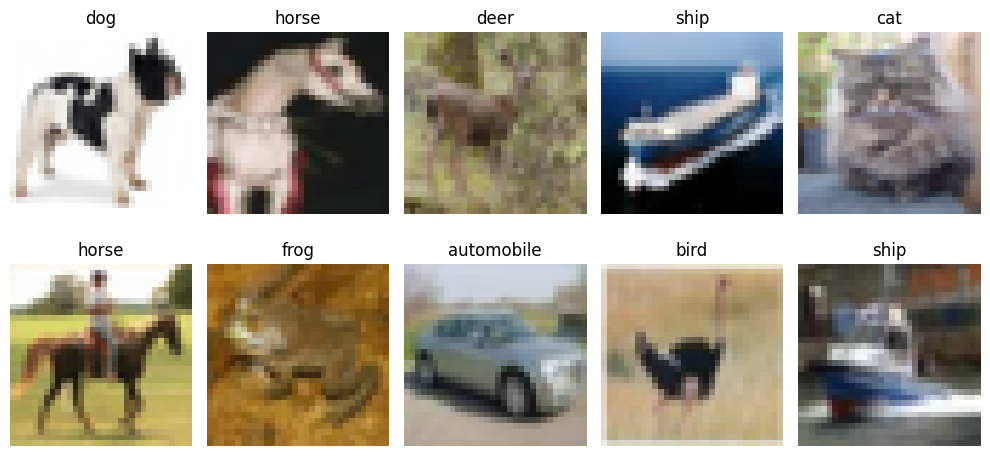

In [4]:
# Просмотр данных
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))

for i in range(10):
    random_index = np.random.randint(0, len(x_train))
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[random_index])
    plt.title(classes[y_train[random_index][0]])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Препроцессинг**

In [5]:
# Нормализация данных
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

## **Разработка архитектуры**

### **Основные - сверточные модели**

In [6]:
# Базовая модель
def standard_model(input_shape=(32, 32, 3), classes=10):
    model = models.Sequential(name='standard-CNN-model')

    # Блок 1
    model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Блок 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Голова
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes, activation='softmax'))

    return model


standard_model = standard_model()
standard_model.summary()

C:\Users\bryzginka\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "standard-CNN-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,138,122 (4.34 MB)

 Trainable params: 1,138,122 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Широкая модель
def wide_model(input_shape=(32, 32, 3), classes=10):
    model = models.Sequential(name='wide-CNN-model')

    # Блок 1
    model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Блок 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Голова
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes, activation='softmax'))

    return model


wide_model = wide_model()
wide_model.summary()

Model: "wide-CNN-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,244,490 (8.56 MB)

 Trainable params: 2,244,490 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Глубокая модель
def deep_model(input_shape=(32, 32, 3), classes=10):
    model = models.Sequential(name='deep-CNN-model')

    # Блок 1
    model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Блок 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Блок 3
    model.add(layers.Conv2D(96, (2, 2), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Голова
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes, activation='softmax'))

    return model


deep_model = deep_model()
deep_model.summary()

Model: "deep-CNN-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 96)            │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 507,434 (1.94 MB)

 Trainable params: 507,434 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Компиляция моделей
standard_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

wide_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

deep_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### **Дополнительная - полносвязная модель**

In [10]:
# Полносвязная модель
def mlp_model(input_shape=(32, 32, 3), classes=10):
    model = models.Sequential(name='mlp-model')

    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())

    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(classes, activation='softmax'))

    return model


mlp_model = mlp_model()
mlp_model.summary()

Model: "mlp-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,812,618 (14.54 MB)

 Trainable params: 3,809,034 (14.53 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [11]:
# Компиляция модели
mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## **Обучение моделей**

In [12]:
# Коллбеки
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [13]:
# Функция визуализации кривых обучения
def learning_curves(history, model):
    plt.figure(figsize=(12, 4))
    plt.suptitle(model, fontweight='bold')
    
    ax_one = plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Обучение')
    plt.plot(history.history['val_accuracy'], label='Валидация')
    plt.title('Точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.legend()
    ax_one.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax_two = plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Обучение')
    plt.plot(history.history['val_loss'], label='Валидация')
    plt.title('Потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    ax_two.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show

### **Сверточные модели**

In [14]:
# Стандартная модель
standard_model_history = standard_model.fit(
    x_train, y_train,
    epochs = 50,
    batch_size = 64,
    validation_split=0.20,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.3480 - loss: 1.7578 - val_accuracy: 0.4933 - val_loss: 1.3984
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5043 - loss: 1.3741 - val_accuracy: 0.5694 - val_loss: 1.2135
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5717 - loss: 1.2038 - val_accuracy: 0.6121 - val_loss: 1.1049
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6132 - loss: 1.0970 - val_accuracy: 0.6538 - val_loss: 0.9805
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6478 - loss: 1.0110 - val_accuracy: 0.6696 - val_loss: 0.9539
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6719 - loss: 0.9384 - val_accuracy: 0.6778 - val_loss: 0.9337
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6947 - loss: 0.8687 - val_accuracy: 0.6864 - val_loss: 0.9095
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7112 - loss: 0.8266 - 

In [15]:
# Широкая модель
wide_model_history = wide_model.fit(
    x_train, y_train,
    epochs = 50,
    batch_size = 64,
    validation_split=0.20,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3321 - loss: 1.7859 - val_accuracy: 0.4879 - val_loss: 1.4235
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4883 - loss: 1.4203 - val_accuracy: 0.5693 - val_loss: 1.2315
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5501 - loss: 1.2605 - val_accuracy: 0.6244 - val_loss: 1.0752
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.5919 - loss: 1.1480 - val_accuracy: 0.6296 - val_loss: 1.0531
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.6300 - loss: 1.0513 - val_accuracy: 0.6513 - val_loss: 0.9920
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [16]:
# Глубокая модель
deep_model_history = deep_model.fit(
    x_train, y_train,
    epochs = 50,
    batch_size = 64,
    validation_split=0.20,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3411 - loss: 1.7635 - val_accuracy: 0.4932 - val_loss: 1.3866
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4981 - loss: 1.3938 - val_accuracy: 0.5506 - val_loss: 1.2294
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5584 - loss: 1.2374 - val_accuracy: 0.6034 - val_loss: 1.1020
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6022 - loss: 1.1231 - val_accuracy: 0.6275 - val_loss: 1.0659
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6366 - loss: 1.0347 - val_accuracy: 0.6607 - val_loss: 0.9631
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


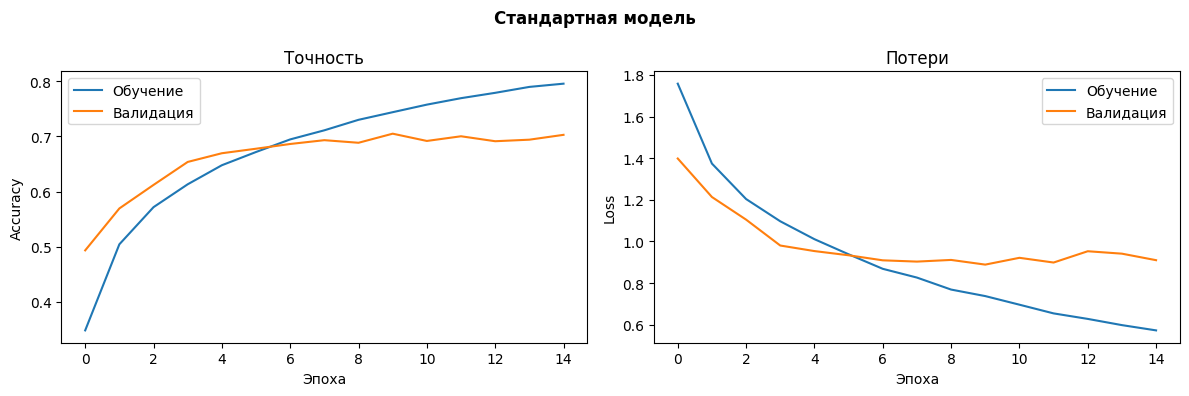

In [17]:
learning_curves(standard_model_history, 'Стандартная модель')

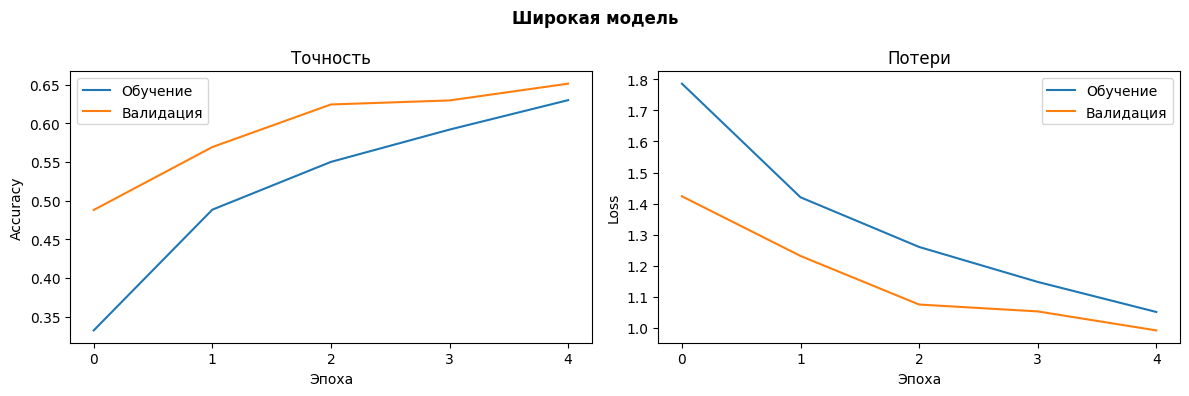

In [18]:
learning_curves(wide_model_history, 'Широкая модель')

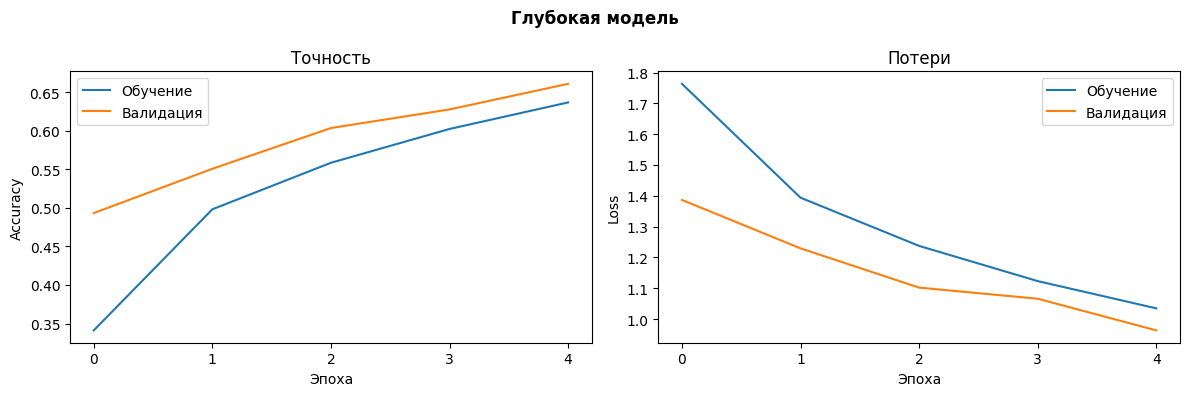

In [19]:
learning_curves(deep_model_history, 'Глубокая модель')

### **Полносвязная модель**

In [20]:
# Полносвязная модель
mlp_model_history = mlp_model.fit(
    x_train, y_train,
    epochs = 50,
    batch_size = 64,
    validation_split=0.20,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.3449 - loss: 1.8557 - val_accuracy: 0.3271 - val_loss: 1.8784
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.4012 - loss: 1.6774 - val_accuracy: 0.3191 - val_loss: 1.9657
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.4216 - loss: 1.6177 - val_accuracy: 0.3678 - val_loss: 1.7776
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.4300 - loss: 1.5869 - val_accuracy: 0.4159 - val_loss: 1.6517
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.4354 - loss: 1.5747 - val_accuracy: 0.3988 - val_loss: 1.6776
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


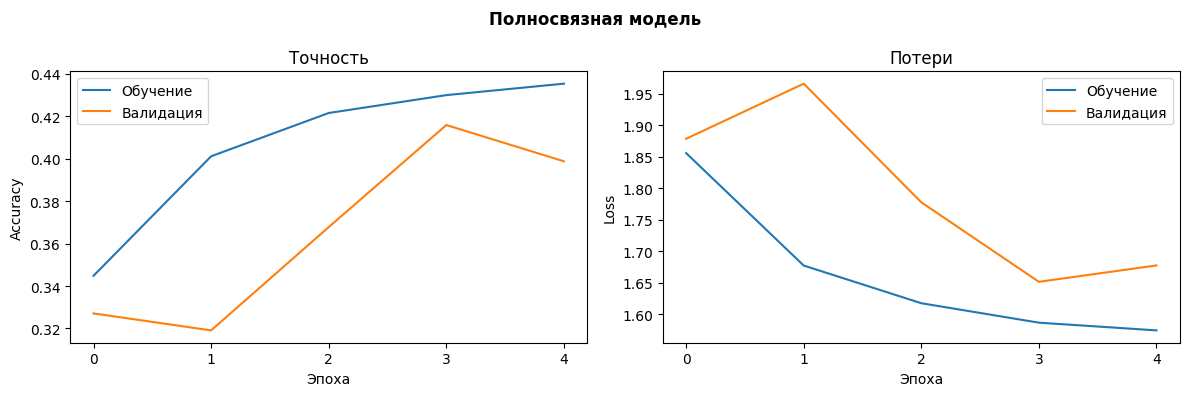

In [21]:
learning_curves(mlp_model_history, 'Полносвязная модель')

## **Оценка моделей**

In [22]:
test_loss, test_acc = standard_model.evaluate(x_test, y_test)
print(f'Модель: {standard_model.name}')
print(f'Точность на тесте: {test_acc:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6977 - loss: 0.8897
Модель: standard-CNN-model
Точность на тесте: 0.70


In [23]:
test_loss, test_acc = wide_model.evaluate(x_test, y_test)
print(f'Модель: {wide_model.name}')
print(f'Точность на тесте: {test_acc:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4840 - loss: 1.4160
Модель: wide-CNN-model
Точность на тесте: 0.48


In [24]:
test_loss, test_acc = deep_model.evaluate(x_test, y_test)
print(f'Модель: {deep_model.name}')
print(f'Точность на тесте: {test_acc:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4976 - loss: 1.3725
Модель: deep-CNN-model
Точность на тесте: 0.50


In [25]:
test_loss, test_acc = mlp_model.evaluate(x_test, y_test)
print(f'Модель: {mlp_model.name}')
print(f'Точность на тесте: {test_acc:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3402 - loss: 1.8455
Модель: mlp-model
Точность на тесте: 0.34


## **Вывод**

1. Разработана и обучена сверточная нейронная сеть standard-CNN-model. В архитектурном решении данная сеть имеет последовательное падение размера ядра свертки (от 5х5 до 3х3) и состоит из двух блоков (свертка + пулинг). Данная сеть использована в качестве базовой модели сверточной сети для сравнения с другимим версиями, где изменены параметры, влияющие на ширину и глубину модели. Значение accuracy на тесте для данной модели составляет 0.70.
2. Разработана и обучена сверточная нейронная сеть wide-CNN-model, где в отличии от базовой модели были изменены значения количества фильтров с 32 до 64 в первом блоке и с 64 до 128 во втором блоке. Данные изменения существенно сказались на оценке качества работы модели, в результате чего значение accuracy на тесте снизилось до 0.48, при этом также снизилось и качество обучения.
3. Разработана и обучена сверточная нейронная сеть deep-CNN-model, где в отличии от базовой модели было увеличен количество блоков (свертка + пулинг) до трех. При этом в последнем блоке также предусмотрено падение ядра свертки (до 2х2), а количество фильтров увеличено до 96. Данные изменения также существенно повлияли на оценку качества работы модели, в результате чего значение accuracy на тесте составило 0.50, что сопоставимо со значением "широкой" модели.
4. Разработана и обучена нейронная сеть mlp-CNN-model, которая хуже всех справилась с классификацией тестовых данных, показатель accuracy 0.34.

Изменение базового варианта сверточной архитектуры в аспекте увеличения ширины или глубины сети, существенно снижает качество работы модели на тестовых данных.

Полносвязная модель плохо справляется с задачей классификации cifar-10.